# Kaggle Bike Sharing Demand

---

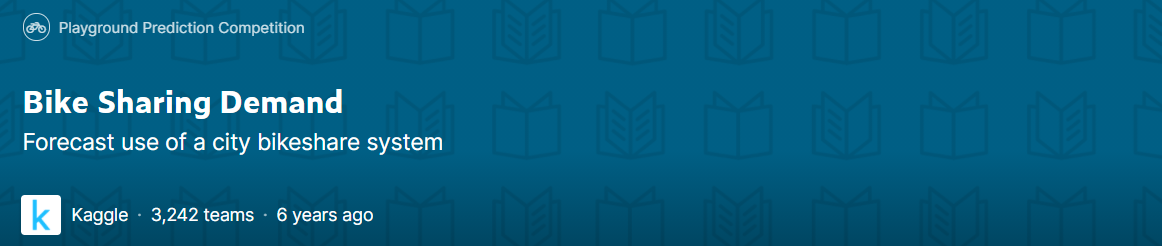

데이터 출처 : https://www.kaggle.com/c/bike-sharing-demand/data

# feature description
---

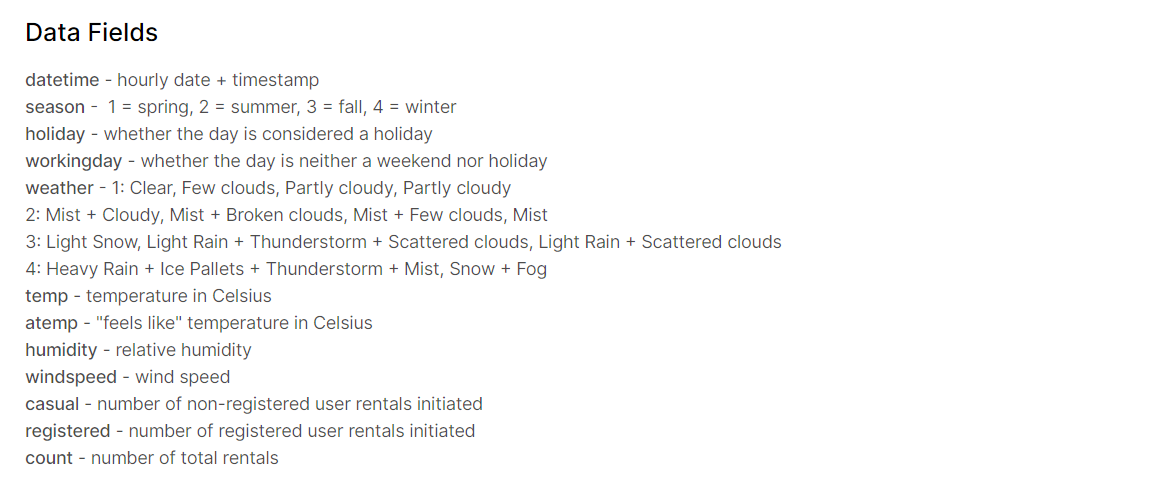

# data preprocessing
---

In [181]:
# 라이브러리 로드

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('../data/bikesharing/train.csv')
test = pd.read_csv('../data/bikesharing/test.csv')
submission = pd.read_csv('../data/bikesharing/sampleSubmission.csv')

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [182]:
# 피처 데이터 타입 및 결측치 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [183]:
# 문자열 datetime 타입으로 변경

train['datetime'] = pd.to_datetime(train['datetime'])

# 년, 월, 일, 시간 추출
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [184]:
# 불필요한 피처 제거
# casual = 사전 미등록 대여 횟수
# registered = 사전 등록 대여 횟수
# count = casual + registered
# count와 casual, registered는 상관도가 높아 성능 저하 가능

drop_cols = ['datetime', 'casual', 'registered']

train.drop(drop_cols, axis=1, inplace=True)

In [185]:
# Competetion 성능 평가 방법은 RMSEL(Root Mean Square Log Error)

from sklearn.metrics import mean_squared_error, mean_absolute_error # MSE, MAE 

# log 변환 시 NaN 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# RMSE
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE : {0:.3f}, RMSE : {1:.3F}, MAE : {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

**log1p() 의 경우 1+log() 갑승로 변환해 오버플로, 언더플로 오류 방지**


**expm1() 함수로 원래 스케일 복원 가능**

In [186]:
# 선형회귀 모델 평가

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso 

X_features = train.drop(['count'], axis=1, inplace=False)
y_target = train['count']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


**count가 수요 예측임을 감안하면 RMSE 140은 큰 오차**

따라서 실제 값과 예측 값의 오차가 가장 큰 데이터 상위 5개 확인

In [187]:
def get_top_error_data(y_test, pred, n_tops=5):
    # DF 칼럼으로 COUNT와 예측값을 비교
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제 값이 가장 큰 데이터 순 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


오차가 500 이상 차이가 나는 것으로 보아 Target 값의 분포가 정규분포 형태를 가지는지 확인

<AxesSubplot:>

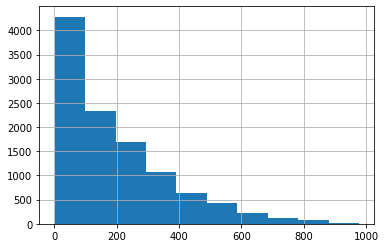

In [188]:
y_target.hist()

target 값의 히스토그램을 확인한 결과 왜곡된 분포를 가진 것을 확인

따라서 로그를 취해 정규분포의 형태를 가지도록 스케일링

<AxesSubplot:>

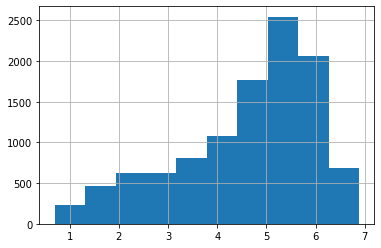

In [189]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

정규분포의 형태에 가깝게 스케일링한 target 데이터를 이용해 모델 재학습

In [190]:
# target값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 target 데이터를 이용해 학습/테스트 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터셋의 target은 로그 변환을 수행했기에 다시 원본 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환되었기에 다시 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


스케일링 전 모델과 비교해 RMSLE는 줄었지만 RMSE는 증가.

따라서 피처 회귀 계수값을 시각화

<AxesSubplot:>

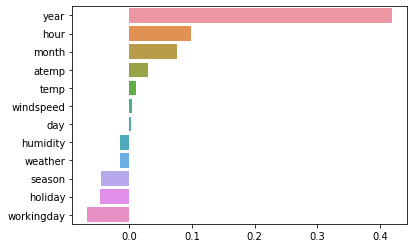

In [191]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

회귀 계수 시각화 결과 year 피처의 회귀 계수가 매우 높은것으로 확인.

자전거 수요의 경우 계절성을 띄지만 연도에 의한 추세는 확인하기 어렵다고 판단

In [192]:
# year 피처의 데이터타입 확인

train.year.dtype

dtype('int64')

year 피처의 데이터 타입은 int로 2011, 2012와 같이 매우 큰 값으로 존재하기 때문에 회귀 계수 연산에 크게 영향을 미치는 것으로 판단.

또한 연도, 월, 일, 시간 등등의 카테고리형 변수에 순위 개념은 존재하지 않기에 원-핫 인코딩을 진행

In [193]:
# 원-핫 인코딩

X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [194]:
# 원-핫 인코딩이 적용된 피처를 기반으로 학습/예측 데이터 분할

X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 셋을 입력하면 성능 평가를 진행하는 함수 정의
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
#####################################################################

# 일반회귀, 릿지, 라쏘 모델 생성
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803


<AxesSubplot:>

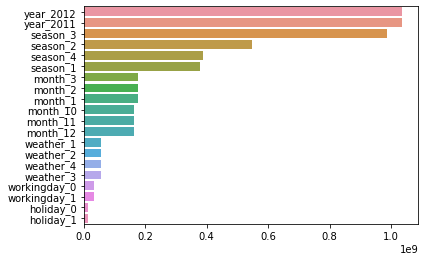

In [195]:
# 원-핫 인코딩으로 인한 회귀 계수가 높은 피처만 일부 시각화

coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

이어서 RandomForest, GBM, XGBoost, LightGBM으로 모델 생성

In [196]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 각 모델별로 평가 진행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.354, RMSE : 50.258, MAE : 31.112
### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.317, MAE : 32.740
### XGBRegressor ###
RMSLE : 0.342, RMSE : 51.732, MAE : 31.251
### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029


LGBMRegressor에서 가장 좋은 성능 확인 LGBMRegressor로 제출

In [ ]:
# 위에서 train sest으로만 원핫인코딩을 진행하여 test 셋을 예측할 수 없는 문제 발생
# 아래 코드 추가

In [218]:
train = pd.read_csv('../data/bikesharing/train.csv')
test = pd.read_csv('../data/bikesharing/test.csv')

total_data = pd.concat([train, test])

total_data['datetime'] = pd.to_datetime(total_data['datetime'])
################################################################
# 년, 월, 일, 시간 추출
total_data['year'] = total_data['datetime'].dt.year
total_data['month'] = total_data['datetime'].dt.month
total_data['day'] = total_data['datetime'].dt.day
total_data['hour'] = total_data['datetime'].dt.hour

drop_cols = ['datetime', 'casual', 'registered']

total_data.drop(drop_cols, axis=1, inplace=True)
################################################################

total_data = pd.get_dummies(total_data)

train = total_data[~total_data['count'].isnull()]

test = total_data[total_data['count'].isnull()]

test = test.drop('count', axis=1)

In [219]:
X_features = train.drop(['count'], axis=1, inplace=False)
y_target = train['count']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

# target값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 target 데이터를 이용해 학습/테스트 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lgbm_reg = LGBMRegressor(n_estimators=500)
lgbm_reg.fit(X_train, y_train)
get_model_predict(lgbm_reg, X_train, X_test, y_train, y_test, is_expm1=True)

### LGBMRegressor ###
RMSLE : 0.301, RMSE : 43.070, MAE : 26.025


In [220]:
submission = pd.read_csv('../data/bikesharing/sampleSubmission.csv')

final_pred = lgbm_reg.predict(test)
submission['count'] += np.expm1(final_pred) # 예측값을 다시 원본 스케일로 변환
submission

,datetime,count
0,2011-01-20 00:00:00,7.353294
1,2011-01-20 01:00:00,3.885620
2,2011-01-20 02:00:00,2.223168
3,2011-01-20 03:00:00,1.944545
4,2011-01-20 04:00:00,1.946575
...,...,...
6488,2012-12-31 19:00:00,258.726148
6489,2012-12-31 20:00:00,178.262870
6490,2012-12-31 21:00:00,161.523609
6491,2012-12-31 22:00:00,111.127686


In [224]:
submission.to_csv('../data/bikesharing/submission.csv', index=False)

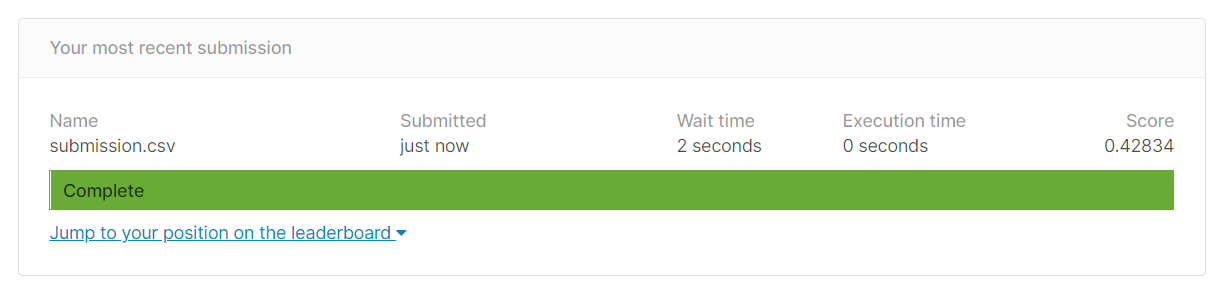

최종적으로 0.42834 라는 점수를 얻었고 이 점수는 약 상위 16%에 해당하는 점수입니다.